# **Netflix Recommendation System**
## (Content-Based Filtering)

In [1]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">TOGGLE TO SEE CODES</button>''', raw=True)

TOGGLE TO SEE CODES

In [2]:
#Imports
import numpy as np
import pandas as pd

#For linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Import CountVectorizer for count matrix
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings("ignore")

In [3]:
#Read data from CSV file
nf = pd.read_csv('netflix_titles.csv')
# nf

nf = nf.fillna('')
nf_tv =  nf.loc[nf['type']=='TV Show', :]
nf_movie =  nf.loc[nf['type']=='Movie', :]
#pd.options.mode.chained_assignment = None  # default='warn'

### 
## MOVIE RECOMMENDATION SYSTEM

## `1. SYSTEM BASED ON DESCRIPTION ONLY` 
### `Using TF-IDF: importance of words, more precise numbers`

In [4]:
##### `Key terms:`
##### `- Term Frequency (TF): `
#####  + The number of times a word appears in a document divded by the total number of words in the document. 
#####  + Every document has its own term frequency.
##### `- Inverse Data Frequency (IDF): `
#####  + The log of the number of documents divided by the number of documents that contain the word w. 
#####  + Inverse data frequency determines the weight of rare words across all

##### `Steps:`
##### 1. Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
##### 2. Construct the required TF-IDF matrix by fitting and transforming the data
##### 3. Compute the cosine similarity matrix
##### 4. Construct a reverse map of indices and movie titles

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1
tfidf = TfidfVectorizer(stop_words='english')

# 2
tfidf_matrix = tfidf.fit_transform(nf_movie['description'])
# tfidf_matrix.shape

# 3
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

indices = pd.Series(nf_movie.index, index=nf_movie['title']).drop_duplicates() #Construct a reverse map of indices and movie titles
# indices

def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices.get(title.title())
    if idx is None:
        return "Movie is not found."

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return nf_movie['title'].iloc[movie_indices]

### `1.1 Test invalid input: Recommendation for movie ""`
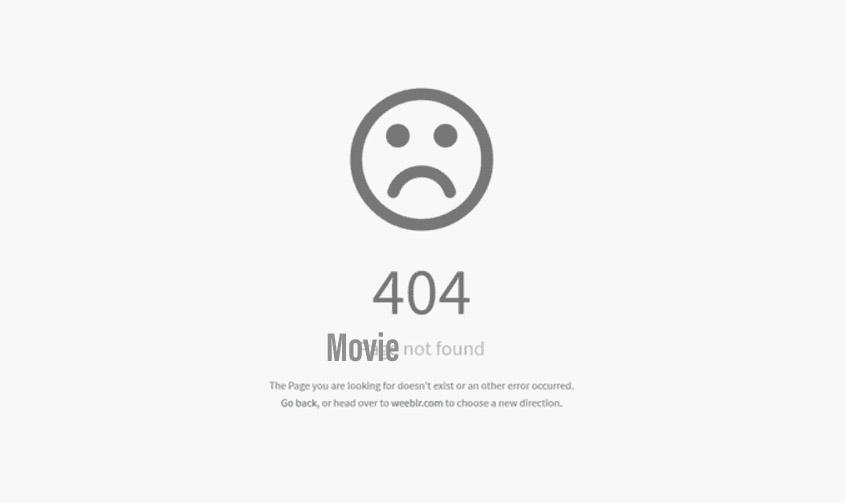
#### *Source: https://www.reddit.com/*
#### *Empty string movie not found*

In [6]:
get_recommendations('')

'Movie is not found.'

### 
### `1.2. Test case-sensitive: Recommendation for movie "The ConjUring"`
#### *Top 10 Movies Recommended*

In [7]:
get_recommendations('The ConjUring')

1964                      High & Low The Movie
1965       High & Low The Movie 2 / End of Sky
1963    DTC Yukemuri Junjo Hen From High & Low
5229                               Bomb Scared
192                                 C Kkompany
2209                                     Nimbe
7745                        Pizza, birra, faso
5303                                Manoranjan
926                         Au coeur des gangs
1609                   Angela's Christmas Wish
Name: title, dtype: object

### 
### `1.3. Test non-letter characters: Recommendation for movie "#Alive"`
#### *Top 10 Movies Recommended*

In [8]:
get_recommendations('#Alive')

427                                    Wannabe Courageous
4451                                     Mumbai Meri Jaan
3147                                              Talaash
206                             LSD: Love, Sex Aur Dhokha
1815    The Magic School Bus Rides Again The Frizz Con...
4719                                         7 Khoon Maaf
1870                              My Step Dad: The Hippie
7703                                           Paper Year
3532                                Ee Nagaraniki Emaindi
745                                        Until Midnight
Name: title, dtype: object

## 
## `2. BASED ON MULTIPLE METRICS`
### `Use CountVectorization: title, cast, director, genre, description`

In [9]:
#### `Steps:`
#### 1. Feature Selection: Define the selected features: 'title', 'director', 'cast', 'listed_in', and 'description'.
#### 2. Combined Feature Creation
#### 3. Count Matrix Creation: Import CountVectorizer from ScikitLearn.
####    + Instantiate CountVectorizer with stop_words set to 'english'.
####    + Create the count matrix using fit_transform on 'combined_features'.
#### 4. Cosine Similarity Calculation: determine how similar each item is to every other item
####    + Compute the cosine similarity matrix based on the count_matrix.
####    + 0 means no similarity
####    + 1 means that both the items are 100% similar.
#### 5. Reverse Index Mapping: map indices back to movie titles when recommending movies
####    + Create a Series of indices mapped to movie titles.
####    + Drop duplicate indices to establish a unique mapping.

In [10]:
def recommendations_movie(title, cosine_sim=cosine_sim):
    idx = indices.get(title.title())
    if idx is None:
        return "Movie not found."

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return nf_movie['title'].iloc[movie_indices]

In [11]:
# 1
features=['title', 'director','cast','listed_in', 'description']
df_features = nf_movie[features]

# 2
def combined_features(x):
    return x['title'] + ' ' + x['director'] + ' ' + x['cast'] + ' ' +x['listed_in']+' '+ x['description']
df_features['combined_features'] = df_features.apply(lambda x: ' '.join(x), axis=1)

# 3
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df_features['combined_features'])

# 4
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim2 = cosine_similarity(count_matrix)

# 5
df_features = df_features.reset_index()
indices = pd.Series(df_features.index, index=df_features['title']).drop_duplicates()
# indices

### `2.1. Recommendation for movie: "The Conjuring"`
#### *Better Recommendation: other movies in the same genre*

In [12]:
recommendations_movie('The Conjuring', cosine_sim2)

1284                                  The Conjuring 2
1118                                        Insidious
3450                                In the Tall Grass
5903                                            Creep
5359                                  Raising the Bar
7168                                           Kanika
5737    I Am the Pretty Thing That Lives in the House
4872                                     Family Blood
5110                                          Creep 2
5042                                       The Ritual
Name: title, dtype: object

### 
### `2.2. Recommendation for movie: "#Alive"` 
#### *Better Recommendations: other movies with supernatural/horror factor* 

In [13]:
recommendations_movie('#Alive', cosine_sim2)

4211               Nang Nak
5317        Berlin Syndrome
2729                   Kaal
4474           Santo Cachón
2589                 Psycho
7168                 Kanika
7280                 Lechmi
1783    The Day of the Lord
1898            The Binding
3698           Inhuman Kiss
Name: title, dtype: object

### 
### `2.3. Recommendation for movie: "High & Low The Movie"`
#### *Better Recommendations: other seasons of this movie* 

In [14]:
recommendations_movie('High & Low The Movie', cosine_sim2)

1969                                  Road To High & Low
1965                 High & Low The Movie 2 / End of Sky
1966              High & Low The Movie 3 / Final Mission
1968                                High & Low The Worst
1967                             High & Low The Red Rain
61      Naruto the Movie 2: Legend of the Stone of Gelel
56              Naruto Shippuden the Movie: Blood Prison
3842                           Gatao 2: Rise of the King
4559                                              Anjaan
5293        Berserk: The Golden Age Arc III - The Advent
Name: title, dtype: object

 ## 
 ## 
 ## TV SHOW RECOMMENDATION SYSTEM
 ### Use CountVectorization: title, cast, director, genre, description

In [15]:
# 1
features=['title', 'director','cast','listed_in', 'description']
df_features = nf_tv[features]

# 2
def combined_features(x):
    return x['title'] + ' ' + x['director'] + ' ' + x['cast'] + ' ' +x['listed_in']+' '+ x['description']
df_features['combined_features'] = df_features.apply(lambda x: ' '.join(x), axis=1)

# 3
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df_features['combined_features'])

# 4
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim2_tv = cosine_similarity(count_matrix)

# 5
df_features = df_features.reset_index()
indices = pd.Series(df_features.index, index=df_features['title']).drop_duplicates()
# indices


def recommendations_tv(title, cosine_sim=cosine_sim2_tv):
    idx = indices.get(title.title())
    if idx is None:
        return "TV Show not found."

    sim_scores = list(enumerate(cosine_sim[idx]))

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    sim_scores = sim_scores[1:11]

    tv_indices = [i[0] for i in sim_scores]

    return nf_tv['title'].iloc[tv_indices]

### `1. Recommendation for show: "Kingdom"`
#### *Results: Other Korean shows* 

In [16]:
recommendations_tv('Kingdom', cosine_sim2_tv)

2255                 Was It Love?
2518                         Iris
686             Hospital Playlist
3270                   Inheritors
2892                        Hyena
2517            Boys Over Flowers
2665    The King: Eternal Monarch
3129         Crash Landing on You
2349     It's Okay to Not Be Okay
3928                      Persona
Name: title, dtype: object

### 
### `2. Recommendation for show: "Stranger Things"`
#### *Results - similar genre* 

In [17]:
recommendations_tv('Stranger Things', cosine_sim2_tv)

5200         Beyond Stranger Things
2190           The Umbrella Academy
2303                    Warrior Nun
1127               Prank Encounters
8803                    Zombie Dumb
3187                    Nightflyers
6167    Anjaan: Special Crimes Unit
241                        Manifest
532                          Scream
880                         Haunted
Name: title, dtype: object

In [18]:
# *Using TF-IDF: TfidfConvertizer*


# features=['title', 'director','cast','listed_in', 'description']
# df_features_tv = nf_tv[features]

# def combined_features(x):
#     return x['title'] + ' ' + x['director'] + ' ' + x['cast'] + ' ' +x['listed_in']+' '+ x['description']

# df_features_tv['combined_features'] = df_features_tv.apply(combined_features, axis=1)

# tfidf = TfidfVectorizer(stop_words='english')
# tfidf_matrix_tv = tfidf.fit_transform(df_features_tv['combined_features'])

# cosine_sim2_tv = linear_kernel(tfidf_matrix_tv, tfidf_matrix_tv)

# df_features_tv = df_features_tv.reset_index()
# indices = pd.Series(df_features_tv.index, index=df_features_tv['title']).drop_duplicates()


# def recommendations_tv(title, cosine_sim=cosine_sim):
#     idx = indices.get(title.title())
#     if idx is None:
#         return "TV show not found."

#     # Get the pairwsie similarity scores of all movies with that movie
#     sim_scores = list(enumerate(cosine_sim[idx]))

#     # Sort the movies based on the similarity scores
#     sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

#     # Get the scores of the 10 most similar movies
#     sim_scores = sim_scores[1:11]

#     # Get the movie indices
#     tv_indices = [i[0] for i in sim_scores]

#     # Return the top 10 most similar movies
#     return nf_tv['title'].iloc[tv_indices]